# Aim

The metadata includes sex information (male/female), and I believe that several behavioral patterns may vary significantly depending on the sex of the mice. In particular, behaviors such as attack, mount, intromission, chase, dominance mount, and ejaculation (although there are only four samples) are likely to be more common in males. On the other hand, behaviors like submission and follow may be more frequently observed in females.

| Action             | Action (Japanese)         | My Hypothesis 
|--------------------|---------------------------| --------------- | 
| attack             | 攻撃                      | Male > Female |
| sniff              | 匂い嗅ぎ                  | | 
| sniffgenital       | 生殖器の匂い嗅ぎ          | |
| approach           | 接近                      | |
| chase              | 追跡                      | Male > Female |
| mount              | マウント                  | Male > Female |
| rear               | 立ち上がり                | |
| escape             | 逃走                      | |
| avoid              | 回避                      | |
| chaseattack        | 追跡攻撃                  | Male > Female |
| submit             | 服従                      | Female > Male | 
| selfgroom          | 自己グルーミング          | |
| sniffface          | 顔の匂い嗅ぎ              | |
| sniffbody          | 体の匂い嗅ぎ              | |
| intromit           | 挿入                      | Male |
| dig                | 掘る                      | |
| follow             | 追従                      | Female > Male |
| defend             | 防御                      | |
| dominancemount     | 優位マウント              | Male > Female |
| attemptmount       | マウント試行              | |
| reciprocalsniff    | 相互匂い嗅ぎ              | |
| allogroom          | 他個体グルーミング        | |
| climb              | よじ登り                  | |
| dominancegroom     | 優位グルーミング          | |
| tussle             | 取っ組み合い              | Male > Female|
| biteobject         | 物を噛む                  | |
| exploreobject      | 物体探索                  | |
| flinch             | ビクッとする              | |
| rest               | 休息                      | |
| disengage          | 離脱                      | |
| run                | 走る                      | |
| genitalgroom       | 生殖器グルーミング        | |
| shepherd           | 追い立て                  | |
| huddle             | 寄り添い                  | |
| freeze             | フリーズ                  | |
| ejaculate          | 射精                      | Male |


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.metrics import f1_score
from sklearn.base import clone

from tqdm import tqdm
import os
import random
import ipywidgets as widgets
import warnings
import json
import gc

In [2]:
class CFG:
    train_path = "/kaggle/input/MABe-mouse-behavior-detection/train.csv"
    test_path = "/kaggle/input/MABe-mouse-behavior-detection/test.csv"
    sample_submission_path = "/kaggle/input/MABe-mouse-behavior-detection/sample_submission.csv"
    train_annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation"
    train_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking"
    test_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/test_tracking"
    output_path = "/kaggle/working/"
    
    mode = "validate"
    # mode = "submit"
    
    n_splits = 3
    cv = StratifiedGroupKFold(n_splits)
    seed = 44
    
    activate_log = True  # for mlflow

# SEED 
os.environ["PYTHONHASHSEED"] = str(CFG.seed) 
rnd = np.random.RandomState(CFG.seed)
random.seed(CFG.seed)
np.random.seed(CFG.seed)

train_df = pd.read_csv(CFG.train_path)
test_df = pd.read_csv(CFG.test_path)
ss_df = pd.read_csv(CFG.sample_submission_path)

In [3]:
# print(train_df["mouse1_sex"].value_counts())
# print(train_df["mouse2_sex"].value_counts())
# print(train_df["mouse3_sex"].value_counts())
# print(train_df["mouse4_sex"].value_counts())

In [4]:
train_df.head()

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,...,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
3,AdaptableSnail,278643799,CD-1 (ICR),white,male,11.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1224,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
4,AdaptableSnail,351967631,CD-1 (ICR),white,male,14.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1204,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [5]:
"""
Data pre-processing
"""
def create_solution_df(dataset):
    solution = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
    
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'): 
            continue
        
        video_id = row['video_id']
        path = f"{CFG.train_annotation_path}/{lab_id}/{video_id}.parquet"
        try:
            annot = pd.read_parquet(path)
        except FileNotFoundError:
            continue

        annot['lab_id'] = lab_id
        annot['video_id'] = video_id
        annot['behaviors_labeled'] = row['behaviors_labeled']
        annot['target_id'] = np.where(annot.target_id != annot.agent_id, annot['target_id'].apply(lambda s: f"mouse{s}"), 'self')
        annot['agent_id'] = annot['agent_id'].apply(lambda s: f"mouse{s}")
        
        solution.append(annot)
    
    solution = pd.concat(solution)
    
    return solution

In [6]:

train_df['n_mice'] = 4 - train_df[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
train_without_mabe22 = train_df.query("~lab_id.str.startswith('MABe22_')")
solution = create_solution_df(train_without_mabe22)

# solution['behaviors_labeled'].iloc[0]
solution.head()

100%|██████████| 863/863 [00:06<00:00, 136.76it/s]


,agent_id,target_id,action,start_frame,stop_frame,lab_id,video_id,behaviors_labeled
0,mouse2,self,rear,4,139,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta..."
1,mouse4,mouse2,avoid,13,52,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta..."
2,mouse4,self,rear,121,172,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta..."
3,mouse3,self,rear,156,213,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta..."
4,mouse4,self,rear,208,261,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta..."


In [7]:
"""
Addeing sex info to the solution data
"""
def add_sex(solution, meta_df=train_df):
    
    sex_cols = [c for c in meta_df.columns if c.endswith("_sex")]
    sex_info = meta_df[["video_id"] + sex_cols].drop_duplicates("video_id")

    solution = solution.copy()
    solution["agent_sex"] = solution.apply(
        lambda row: sex_info.loc[
            sex_info["video_id"] == row["video_id"],
            row["agent_id"] + "_sex"
        ].iloc[0],
        axis=1
    )

    return solution


In [8]:
solution = add_sex(solution, train_df)
solution.head()

,agent_id,target_id,action,start_frame,stop_frame,lab_id,video_id,behaviors_labeled,agent_sex
0,mouse2,self,rear,4,139,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",male
1,mouse4,mouse2,avoid,13,52,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",male
2,mouse4,self,rear,121,172,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",male
3,mouse3,self,rear,156,213,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",male
4,mouse4,self,rear,208,261,AdaptableSnail,44566106,"[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",male


# Analyze

## Agent sex & its action

In [15]:
def plot_action_distribution_by_sex(solution):

    df = solution.dropna(subset=["agent_sex"])

    # Aggregate by male and female
    df_male = df[df["agent_sex"] == "male"]["action"].value_counts(normalize=True)
    df_female = df[df["agent_sex"] == "female"]["action"].value_counts(normalize=True)

    all_actions = sorted(set(df_male.index) | set(df_female.index))

    action_total = {act: df_male.get(act, 0) + df_female.get(act, 0) for act in all_actions}
    all_actions_sorted = sorted(all_actions, key=lambda a: action_total[a], reverse=True)

    male_vals = [df_male.get(act, 0) for act in all_actions_sorted]
    female_vals = [df_female.get(act, 0) for act in all_actions_sorted]

    x = np.arange(len(all_actions_sorted))
    width = 0.4

    plt.figure(figsize=(15,6))
    plt.bar(x - width/2, male_vals, width, label="Male", color="steelblue")
    plt.bar(x + width/2, female_vals, width, label="Female", color="orange")

    plt.xticks(x, all_actions_sorted, rotation=90)
    plt.ylabel("Percentage")
    plt.title("Action Distribution by Sex (Sorted)")
    plt.legend()
    plt.tight_layout()
    plt.show()


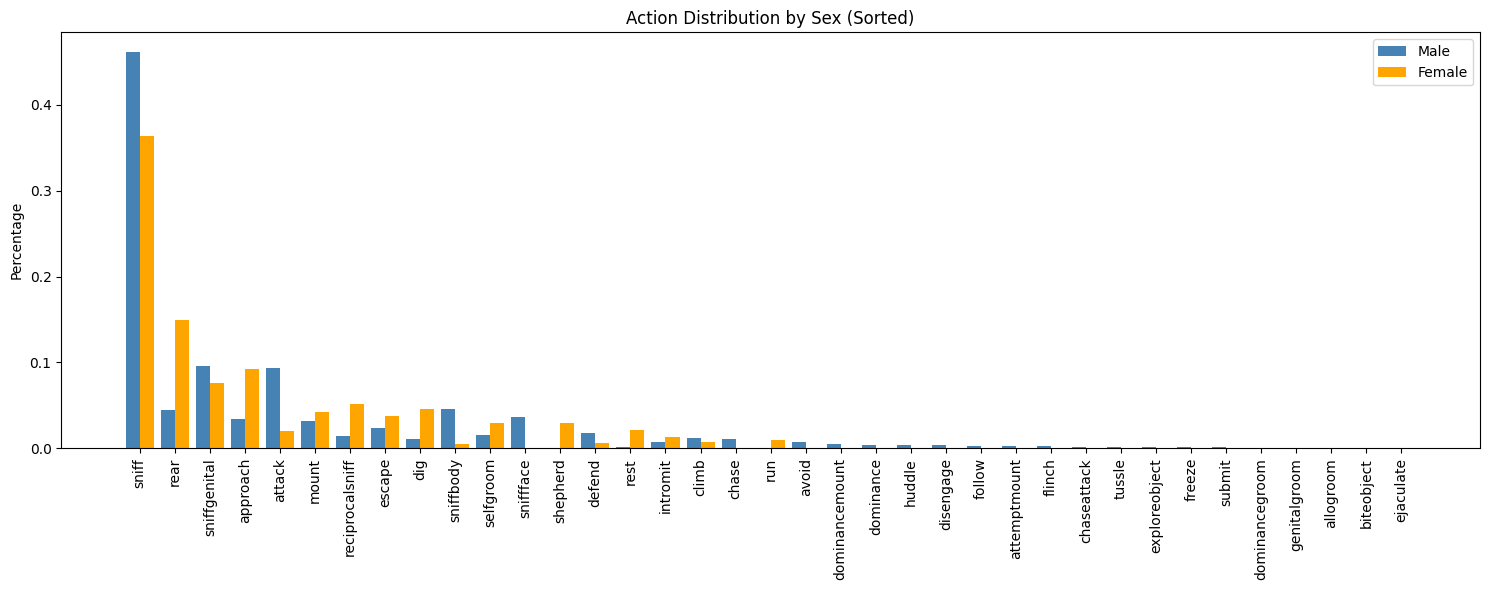

In [16]:
plot_action_distribution_by_sex(solution)

# Summary

According to the results, there is no significant difference in action distribution between males and females, although some labels such as shepherd do not appear in males, and vice versa.
Moreover, the imbalance in the dataset with respect to both sex and action labels makes it **difficult to effectively utilize sex as a feature** without causing overfitting.

In addition, according to the competition notes, each lab has its own goals and tends to focus on specific behaviors, meaning that some actions are not labeled at all by certain labs. Therefore, these distributions may not be useful for building a generalizable model.